# SPRAWL usage with custom Tagged BAM files for ReadZS analysis

In [1]:
from sprawl import vignette, utils
import pysam

## BAM files used in SPRAWL paper have a custom 'XO' tag to specify cell-type

We need to calculate ReadZS-proxy scores per gene per cell-type from the 10X single-cell RNA seq data

Normally cell-type metadata is stored in a separate .csv/.tsv file from the aligned .bam file from the scRNAseq dataset, and cross-referenced with the cell-barcode, but we've made the decision to directly include the cell-type info inside the .bam

This is possible because the .sam/.bam standard, [described here](https://samtools.github.io/hts-specs/SAMv1.pdf), allows for the use of "end-user defined tags" which start with 'X?'. We've used the `XO` tag to include the `cell-type` data.

**What are .bam tags?**
They are fields for extra information at the end of each read alignment line which provide direct and metadata info for things such as:
* `NH` Number of alignments
* `AS` Alignment score
* `CB` cellular barcode (applicable for scRNAseq, but not bulk sequencing)
* `RG` read-group
* ...

.bam tags work as key-value pairs like a python `dict` with a two-letter key and then a value.
For a full list of reserved and user-definable tags refer to [here](https://samtools.github.io/hts-specs/SAMtags.pdf).

**How do I work with .bam tags in python?**
One option, and the one used by `SPRAWL`, is to use the `pysam` package which makes it easy to access and modify tags from .bam `AlignmentFiles`. Below is an example of how to view .bam tags in pysam. These files are included as vignette data in the `SPRAWL` package and shouldn't need to be downloaded separately.


**Description of subsequent code**
1. Create a helper function `summarize_read` which takes a `pysam` read object as input and prints out mapping information and also .bam tag info in a nice table.
  
2. Read in a .bam file which **DOES NOT** have `XO` tags for the mappings and print out the 1st read to show this

3. Read in an identical .bam file which **DOES** have `XO` tags for the mappings and print out the 1st read to show this. The 1st read is from an `L5_IT` typed cell

In [2]:
def summarize_read(r):
    """
    Function to pretty print fields from a pysam read
    """
    #only printing a subset of the tags
    #meanings for all tags taken from https://samtools.github.io/hts-specs/SAMtags.pdf
    tag_meanings = {
        'NH':'Num alignments  ',
        'AS':'Alignment score ',
        'BC':'Sample barcode  ',
        'CB':'Cellular barcode',
        'XO':'Cell-type       ',
    }
    
    print('Read name  :',r.qname)
    print('Read seq   :',r.seq)
    print('Map flag   :',r.flag)
    print('Map pos    :',r.pos)
    print('Map contig :',r.reference_name)
    print('Map quality:',r.mapq)
    print('CIGAR      :',r.cigarstring)
    
    print('\n      Meaning       Tag       Value')
    print('------------------|----|---------------------')
    
    for tag,meaning in tag_meanings.items():
        #pysam read object `has_tag` and `get_tag` accessors are helpful
        if r.has_tag(tag):
            v = r.get_tag(tag)
        else:
            v = '[TAG ABSENT]'
        print(f'{meaning}  | {tag} | {v}')
        
        
#path to bam file WITHOUT cell-type annotations in the included vignette data
untagged_bam_path = vignette.get_data_path('no_ont.bam')

with pysam.AlignmentFile(untagged_bam_path) as bam:
    print('There are',bam.count(),'reads in the UNTAGGED bam')

    #extract the first read from the bam to show what fields it has
    r = next(bam.fetch())
    summarize_read(r)
    
print('')
print('')
    
#path to the same bam file WITH cell-type annotations in the included vignette data
tagged_bam_path = vignette.get_data_path('ont_ann.bam')

with pysam.AlignmentFile(tagged_bam_path) as bam:
    print('There are',bam.count(),'reads in the TAGGED bam')

    #extract the first read from the bam to show what fields it has
    r = next(bam.fetch())
    summarize_read(r)
    

There are 3441 reads in the UNTAGGED bam
Read name  : A00177:68:HJW2TDSXX:3:1373:10357:10755
Read seq   : GGCTTTTTTTTTTTTTTTTTTTTTTTTTGGAGTCCACCTTCTTGAGTTCTTTATATATATTGGATATTAGTCCCCTATCCGATTTGGGATA
Map flag   : 16
Map pos    : 3000094
Map contig : chr1
Map quality: 255
CIGAR      : 22M15932N69M

      Meaning       Tag       Value
------------------|----|---------------------
Num alignments    | NH | 1
Alignment score   | AS | 80
Sample barcode    | BC | TCGGCGTC
Cellular barcode  | CB | TACCTCGTCAGCTTCC-1
Cell-type         | XO | [TAG ABSENT]


There are 3441 reads in the TAGGED bam
Read name  : A00177:68:HJW2TDSXX:3:1373:10357:10755
Read seq   : GGCTTTTTTTTTTTTTTTTTTTTTTTTTGGAGTCCACCTTCTTGAGTTCTTTATATATATTGGATATTAGTCCCCTATCCGATTTGGGATA
Map flag   : 16
Map pos    : 3000094
Map contig : chr1
Map quality: 255
CIGAR      : 22M15932N69M

      Meaning       Tag       Value
------------------|----|---------------------
Num alignments    | NH | 1
Alignment score   | AS | 80
Sample barcode  

## How to add tags to bam files using `pysam`

Small example showing how the 'XO' tag was added to the .bam files for SPRAWL. The organization of your cell-type metadata might be different, but there needs to be some mapping from cell-barcode to cell-type

In [3]:
%%time
#path to bam file WITHOUT cell-type annotations in the included vignette data
untagged_bam_path = vignette.get_data_path('no_ont.bam')
in_bam = pysam.AlignmentFile(untagged_bam_path)

#create an output bam which will have the XO tag added for each read
tagged_out_bam_path = 'out.bam'
out_bam = pysam.AlignmentFile('out.bam', 'wb', template=in_bam)

#need to have some mapping from Cell-barcode to cell-type (maybe a .csv/.tsv?)
#this is just an example, so I'm creating fake data as a dict
barcode_to_celltype = {
    'ACATCCCAGACTGGGT-1':'L5_CT',
    'CAACGGCCAGAGATTA-1':'L6_CT',
    'CACACAAAGCTATCTG-1':'Oligodendrocyte',
    'GGTTCTCCAGCTACCG-1':'Astrocyte',
    'TACCTCGTCAGCTTCC-1':'L5_IT',
    'TATTGGGAGATGCTAA-1':'PVALB',
}


#iterate through the reads in the input bam
#  1. Get the cell barcode from the read
#  2. Get the associated celltype from our mapping above (or 'no_celltype' if no match)
#  3. Set the 'XO' tag to be the cell_type on our read
#  4. Write out the read to the new .bam file
for r in in_bam.fetch():
    barcode = r.get_tag('CB')
    cell_type = barcode_to_celltype.get(barcode,'no_celltype')
    r.set_tag('XO',cell_type)

    out_bam.write(r)
    

#close the file handles
out_bam.close()
in_bam.close()


#create a .bam.bai index for the new file (needed for .fetch access)
#don't need to sort because the reads were already sorted in the in_bam file
pysam.index(tagged_out_bam_path)

#very fast for this example dataset which only has 3,441 reads
#can be slow on large .bam files since it processes one read at a time

CPU times: user 158 ms, sys: 6.75 ms, total: 165 ms
Wall time: 677 ms


''

In [4]:
#read in the created output file and make sure that there is now an XO tag (just checking the first read)
with pysam.AlignmentFile(tagged_out_bam_path) as bam:
    r = next(bam.fetch())
    summarize_read(r)

Read name  : A00177:68:HJW2TDSXX:3:1373:10357:10755
Read seq   : GGCTTTTTTTTTTTTTTTTTTTTTTTTTGGAGTCCACCTTCTTGAGTTCTTTATATATATTGGATATTAGTCCCCTATCCGATTTGGGATA
Map flag   : 16
Map pos    : 3000094
Map contig : chr1
Map quality: 255
CIGAR      : 22M15932N69M

      Meaning       Tag       Value
------------------|----|---------------------
Num alignments    | NH | 1
Alignment score   | AS | 80
Sample barcode    | BC | TCGGCGTC
Cellular barcode  | CB | TACCTCGTCAGCTTCC-1
Cell-type         | XO | L5_IT


## Calculating ReadZS proxy scores from the example bam with the 'XO' tag

In [5]:
#visualizing the read buildup of the example data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = {
    'chrom':[],
    'pos':[],
    'cell_type':[],
}

tagged_bam_path = vignette.get_data_path('ont_ann.bam')

with pysam.AlignmentFile(tagged_bam_path) as bam:
    for r in bam.fetch():
        data['chrom'].append(r.reference_name)
        data['pos'].append(r.pos)
        data['cell_type'].append(r.get_tag('XO'))
        
read_pos_df = pd.DataFrame(data)
read_pos_df

,chrom,pos,cell_type
0,chr1,3000094,L5_IT
1,chr1,3000097,L6_IT
2,chr1,3000255,L6_IT
3,chr1,3000264,L6_IT
4,chr1,3000333,L5_IT
...,...,...,...
3436,JH584295.1,69,L56_NP
3437,JH584295.1,69,L6_CT
3438,JH584295.1,69,L23_IT
3439,JH584295.1,69,L23_IT


In [6]:
#chr5 has the most number of reads (73) and 5 different cell-types with between 1 and 36 reads
#(this is very sparse example data)
reads_per_chrom_ct = read_pos_df.groupby(['chrom','cell_type']).size().reset_index(name='num_reads')
reads_per_chrom_ct['chrom_sum'] = reads_per_chrom_ct.groupby('chrom')['num_reads'].transform('sum')

reads_per_chrom_ct.sort_values('chrom_sum', ascending=False).head(6)

,chrom,cell_type,num_reads,chrom_sum
392,chr5,L23_IT,36,73
393,chr5,L5_IT,24,73
394,chr5,L6_CT,5,73
396,chr5,Sst,1,73
395,chr5,L6_IT,7,73
288,chr1,L56_NP,3,71


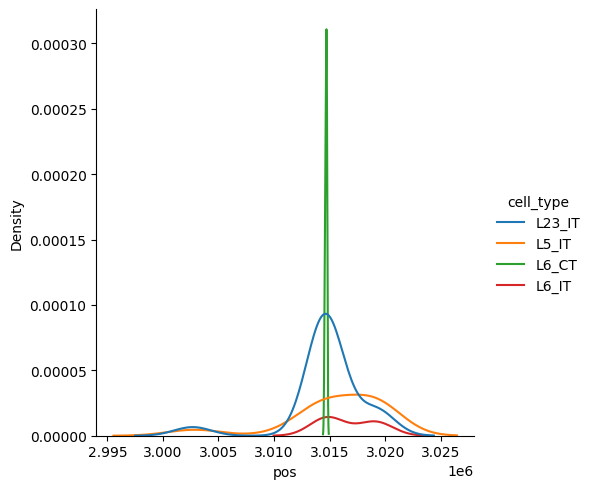

In [7]:
#visualizing the distribution of reads for each cell-type on chr5 in the example data

plot_df = read_pos_df[
    read_pos_df['chrom'].eq('chr5') #select reads mapping to chr5
    & read_pos_df['cell_type'].ne('Sst') #skip SST since it only has 1 read
]

sns.displot(
    x = 'pos',
    kind = 'kde',
    hue = 'cell_type',
    data = plot_df,
)
plt.show()
plt.close()

In [8]:
#ReadZS proxy score for the region above, treating all reads as if they are from the same cell-type 'All'
#the value of 0.44 makes intuitive sense since the 'read-mass' is shifted to the right of the middle of this region

readzs_scores = utils.readzs_proxy_score(
    bam_path = vignette.get_data_path('ont_ann.bam'),
    locus = ('chr5',3002511,3019364), #this is the region for the graph above, would be gene 3' UTR in real analysis
    #strand = '+', #select only reads on this specific strand, uses both strands if not specified
    #stratify_tag = 'XO', #which .bam tag to stratify by? if not specified, all reads are considered part of 'All'
    #min_tag_reads = 1, #require at least x reads for an ontology to be included (over any number of cells)
)

readzs_scores

{'All': 0.4405743784489408}

In [9]:
#ReadZS scores per cell-type (stratified by the 'XO' tag) are all similar
#L6_CT has the largest ReadZS score meaning that it is the most 'right-shifted' which looks correct in the graph above

readzs_scores = utils.readzs_proxy_score(
    bam_path = vignette.get_data_path('ont_ann.bam'),
    locus = ('chr5',3002511,3019364), #this is the region for the graph above
    stratify_tag = 'XO', #stratify by the 'XO' .bam tag
    min_tag_reads = 2, #require at least 2 reads for a cell-type to be included
)

readzs_scores

{'L23_IT': 0.4354714294190945,
 'L5_IT': 0.450542930042129,
 'L6_CT': 0.44603334717854387,
 'L6_IT': 0.4955200854447279}

## Closing thoughts

* The .bam files used by SPRAWL for ReadZS-proxy analysis have an extra 'XO' tag which stores the cell-type data directly in the .bam file, which is arguably a good idea or not

* `pysam` can be used to create a new .bam file with 'XO' tags from an existing .bam (with cell-barcode to cell-type mapping)

* the `utils.readzs_proxy_score` function can be run on bams that don't have 'XO' tags, in which case it assumes all reads originate from the same cell-type `'All'`. Can also be run on files with 'XO' tags to get a cell-type specific

* the notebook analysis/localization_regulation_by_cis_element/merfish_BICCN.ipynb shows how `utils.readzs_proxy_score` in the SPRAWL paper